# Semaine 13 - Reinforcement Learning, Q-learning

Dans l'exercice de cette semaine, nous utiliserons le module *Gym* d'OpenAI. Gym implémente divers environnements compatibles avec des problèmes de RL pour permettre à la communauté scientifique de s'y entraîner.

Voici le lien vers la documentation de *Gym*:   https://gym.openai.com/docs/

In [1]:
import gym
from gym import wrappers
import numpy as np

# L'environnement

Dans MountainCar, il faire à apprendre au pilote de la voiture comment monter au sommet de la montagne. Mais le moteur n'a pas assez de puissance pour y arriver d'un coup.

In [2]:
env = gym.make('MountainCar-v0')
env.reset()
for timestep in range(200):
    env.render()
    env.step(2)
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Le pilote dispose de 3 actions possibles:

In [3]:
env.action_space.n

3

Testez différentes valeurs pour la variable "action" afin de découvrir comment est encodé le choix de l'action pour le passer à l'environnement au travers de la méthode step()

In [4]:
action = 0

env = gym.make('MountainCar-v0')
env.seed(42)
env.reset()
for timestep in range(200):
    env.render()
    env.step(action)
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


# Les observations et les états

L'environnement fournit à l'agent deux valeurs continues comme observation:

In [5]:
env.observation_space

Box(2,)

Une des valeurs correspond à la position, l'autre à la vitesse

Les observations sont renvoyées par deux différentes méthodes de l'environnement:

In [6]:
observation = env.reset()
print(observation)
observation, reward, done, info = env.step(action)
print(observation)

[-0.50313229  0.        ]
[-0.50428569 -0.0011534 ]


Pour faire du q-learning, il faut un nombre fini d'état, donc nos valeurs continues doivent devenir discrètes. Écrivez une fonction qui divise l'échelle de variation de chaque valeur en 20 segments égaux.

In [7]:
n_segments = 20

def obs_to_state(obs):
    min_position, min_speed = env.observation_space.low
    max_position, max_speed = env.observation_space.high
    position, speed = obs
    
    position_delta = (max_position - min_position) / n_segments
    speed_delta = (max_speed - min_speed) / n_segments
    position_segm = int((position-min_position)/position_delta)
    speed_segm = int((speed-min_speed)/speed_delta)
    
    state = position_segm, speed_segm
    return state

Testez votre fonction: Faites-lui transformer l'observtion

In [8]:
obs_to_state(observation)

(7, 9)

# L'agent 

Par souci de simplicité, nous n'allons pas implémenter l'agent comme objet, mais néanmoins nous implémenterons sa Policy!

### Q-Table

Créez une table de q-valeurs qui peut contenir une q-valeur distincte pour chaque action possible, dans tous les états imaginables!
Attention, si l'état est représenté en deux dimensions, il faut ajouter une troisième dimension correspondant au nombre d'actions possibles.

In [9]:
np.random.seed(42)

dimensions = (n_segments, n_segments, env.action_space.n)
q_table = np.random.uniform(low=-1, high=1, size=dimensions)

### Policy 

Implémentez la Greedy policy, qui utilise la q_table pour décider de la meilleure action à choisir

In [10]:
def greedy_policy(state):
    action = np.argmax(q_table[state])
    return action

Implémentez maintenant la Epsilon-greedy policy, qui ajoute une probabilité *epsilon* que l'action soit choisie aléatoirement  
_**Indice:**_ np.random.choice(n) choisira aléatoirement un nombre de 0 à n exclus

In [11]:
def epsilon_greedy_policy(state, epsilon):
    if np.random.rand(1) < epsilon:
        action = np.random.choice(env.action_space.n)
    else:
        action = greedy_policy(state)
    return action

# L'entraînement

In [12]:
import pdb
import numpy as np
np.random.seed(42)

# Parameters
episodes_max = 5000
lr = 0.2
gamma = 1

# Epsilon will diminish over the episodes to increase exploitation
start_epsilon = 0.8
final_epsilon = 0
epsilon_reduction = (start_epsilon - final_epsilon) / episodes_max
epsilon = start_epsilon

reward_list = []
avg_reward_list = []

# Train for 'episodes_max' episodes
for episode in range(episodes_max):
    
    # Initialize parameters of the episode
    total_reward = 0
    done = False
    obs = env.reset()
    state1 =  obs_to_state(obs)
    """N'oubliez pas de transformer ce que retourne l'environment en valeurs discrètes!"""
    
    # Each episode runs for a maximum of 200 timesteps, at whith point the Environment returns done = True
    while done is False:
        
        # The agent chooses an action
        action = epsilon_greedy_policy(state1, epsilon)
        
        # The action is given to the environment, which returns a new state, a reward, and some other info
        # (see documentation https://gym.openai.com/docs/)
        obs, reward, done, _ = env.step(action)
        
        state2 = obs_to_state(obs)
        
        total_reward += reward
        
        # Update q_table
        if done:
            """Quelle est la q-valeur de la toute dernière action???"""
            q_table[state1][action] = reward
        else:
            """Hmmmm... On dirait qu'on va s'amuser avec l'équation de Bellman!!"""
            q_table[state1][action] = (1-lr)*q_table[state1][action] + lr*(reward + gamma * np.max(q_table[state2]))
        
        # The new state becomes state1 of the next loop
        state1 = state2
    
    # Epsilon decay
    epsilon -= epsilon_reduction
    
    # Display rewards
    reward_list.append(total_reward)
    if (episode + 1) % 100 == 0:
        avg_reward = np.mean(reward_list)
        avg_reward_list.append(avg_reward)
        reward_list = []
        print('Iteration #{} -- Average reward = {}'.format(episode+1, avg_reward))

Iteration #100 -- Average reward = -200.0
Iteration #200 -- Average reward = -200.0
Iteration #300 -- Average reward = -200.0
Iteration #400 -- Average reward = -200.0
Iteration #500 -- Average reward = -200.0
Iteration #600 -- Average reward = -200.0
Iteration #700 -- Average reward = -200.0
Iteration #800 -- Average reward = -200.0
Iteration #900 -- Average reward = -200.0
Iteration #1000 -- Average reward = -200.0
Iteration #1100 -- Average reward = -200.0
Iteration #1200 -- Average reward = -200.0
Iteration #1300 -- Average reward = -200.0
Iteration #1400 -- Average reward = -200.0
Iteration #1500 -- Average reward = -200.0
Iteration #1600 -- Average reward = -200.0
Iteration #1700 -- Average reward = -200.0
Iteration #1800 -- Average reward = -200.0
Iteration #1900 -- Average reward = -200.0
Iteration #2000 -- Average reward = -200.0
Iteration #2100 -- Average reward = -200.0
Iteration #2200 -- Average reward = -200.0
Iteration #2300 -- Average reward = -200.0
Iteration #2400 -- A

## La mise à l'épreuve 

On veut maintenant voir notre agent en action avec la Policy optimale. Quelle fonction utilisera-t-on pour sélectionner chaque action?

In [13]:
env = gym.make('MountainCar-v0')
state = obs_to_state(env.reset())
done = False
while done is False:
    env.render()
    action = greedy_policy(state)
    obs, reward, done, _ = env.step(action)
    state = obs_to_state(obs)
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


## Évolution de l'entraînement

Un petit graphique pour voir l'évolution du Return moyen de chaque tranche de 100 épisodes

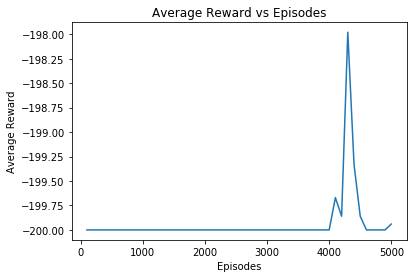

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(100*(np.arange(len(avg_reward_list)) + 1), avg_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')
plt.show()